In [44]:
import torch
import numpy as np
import os, imageio
import matplotlib.pyplot as plt

In [2]:
########## Slightly modified version of LLFF data loading code 
##########  see https://github.com/Fyusion/LLFF for original

def _minify(basedir, factors=[], resolutions=[]):
    needtoload = False
    for r in factors:
        imgdir = os.path.join(basedir, 'images_{}'.format(r))
        if not os.path.exists(imgdir):
            needtoload = True
    for r in resolutions:
        imgdir = os.path.join(basedir, 'images_{}x{}'.format(r[1], r[0]))
        if not os.path.exists(imgdir):
            needtoload = True
    if not needtoload:
        return
    
    from shutil import copy
    from subprocess import check_output
    
    imgdir = os.path.join(basedir, 'images')
    imgs = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir))]
    imgs = [f for f in imgs if any([f.endswith(ex) for ex in ['JPG', 'jpg', 'png', 'jpeg', 'PNG']])]
    imgdir_orig = imgdir
    
    wd = os.getcwd()

    for r in factors + resolutions:
        if isinstance(r, int):
            name = 'images_{}'.format(r)
            resizearg = '{}%'.format(100./r)
        else:
            name = 'images_{}x{}'.format(r[1], r[0])
            resizearg = '{}x{}'.format(r[1], r[0])
        imgdir = os.path.join(basedir, name)
        if os.path.exists(imgdir):
            continue
            
        print('Minifying', r, basedir)
        
        os.makedirs(imgdir)
        check_output('cp {}/* {}'.format(imgdir_orig, imgdir), shell=True)
        
        ext = imgs[0].split('.')[-1]
        args = ' '.join(['mogrify', '-resize', resizearg, '-format', 'png', '*.{}'.format(ext)])
        print(args)
        os.chdir(imgdir)
        check_output(args, shell=True)
        os.chdir(wd)
        
        if ext != 'png':
            check_output('rm {}/*.{}'.format(imgdir, ext), shell=True)
            print('Removed duplicates')
        print('Done')
            
        
        
        
def _load_data(basedir, factor=None, width=None, height=None, load_imgs=True):
    
    poses_arr = np.load(os.path.join(basedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])
    
    img0 = [os.path.join(basedir, 'images', f) for f in sorted(os.listdir(os.path.join(basedir, 'images'))) \
            if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')][0]
    sh = imageio.imread(img0).shape
    
    sfx = ''
    
    if factor is not None:
        sfx = '_{}'.format(factor)
        _minify(basedir, factors=[factor])
        factor = factor
    elif height is not None:
        factor = sh[0] / float(height)
        width = int(sh[1] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    elif width is not None:
        factor = sh[1] / float(width)
        height = int(sh[0] / factor)
        _minify(basedir, resolutions=[[height, width]])
        sfx = '_{}x{}'.format(width, height)
    else:
        factor = 1
    
    imgdir = os.path.join(basedir, 'images' + sfx)
    if not os.path.exists(imgdir):
        print( imgdir, 'does not exist, returning' )
        return
    
    imgfiles = [os.path.join(imgdir, f) for f in sorted(os.listdir(imgdir)) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]
    if poses.shape[-1] != len(imgfiles):
        print( 'Mismatch between imgs {} and poses {} !!!!'.format(len(imgfiles), poses.shape[-1]) )
        return
    
    sh = imageio.imread(imgfiles[0]).shape
    poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1])
    poses[2, 4, :] = poses[2, 4, :] * 1./factor
    
    if not load_imgs:
        return poses, bds
    
    def imread(f):
        if f.endswith('png'):
            return imageio.imread(f, ignoregamma=True)
        else:
            return imageio.imread(f)
        
    imgs = imgs = [imread(f)[...,:3]/255. for f in imgfiles]
    imgs = np.stack(imgs, -1)  
    
    print('Loaded image data', imgs.shape, poses[:,-1,0])
    return poses, bds, imgs

    
            
            
    

def normalize(x):
    return x / np.linalg.norm(x)

def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

def ptstocam(pts, c2w):
    tt = np.matmul(c2w[:3,:3].T, (pts-c2w[:3,3])[...,np.newaxis])[...,0]
    return tt

def poses_avg(poses):

    hwf = poses[0, :3, -1:]

    center = poses[:, :3, 3].mean(0)
    vec2 = normalize(poses[:, :3, 2].sum(0))
    up = poses[:, :3, 1].sum(0)
    c2w = np.concatenate([viewmatrix(vec2, up, center), hwf], 1)
    
    return c2w



def render_path_spiral(c2w, up, rads, focal, zdelta, zrate, rots, N):
    render_poses = []
    rads = np.array(list(rads) + [1.])
    hwf = c2w[:,4:5]
    
    for theta in np.linspace(0., 2. * np.pi * rots, N+1)[:-1]:
        c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) 
        z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.])))
        render_poses.append(np.concatenate([viewmatrix(z, up, c), hwf], 1))
    return render_poses
    


def recenter_poses(poses):

    poses_ = poses+0
    bottom = np.reshape([0,0,0,1.], [1,4])
    c2w = poses_avg(poses)
    c2w = np.concatenate([c2w[:3,:4], bottom], -2)
    bottom = np.tile(np.reshape(bottom, [1,1,4]), [poses.shape[0],1,1])
    poses = np.concatenate([poses[:,:3,:4], bottom], -2)

    poses = np.linalg.inv(c2w) @ poses
    poses_[:,:3,:4] = poses[:,:3,:4]
    poses = poses_
    return poses


#####################


def spherify_poses(poses, bds):
    
    p34_to_44 = lambda p : np.concatenate([p, np.tile(np.reshape(np.eye(4)[-1,:], [1,1,4]), [p.shape[0], 1,1])], 1)
    
    rays_d = poses[:,:3,2:3]
    rays_o = poses[:,:3,3:4]

    def min_line_dist(rays_o, rays_d):
        A_i = np.eye(3) - rays_d * np.transpose(rays_d, [0,2,1])
        b_i = -A_i @ rays_o
        pt_mindist = np.squeeze(-np.linalg.inv((np.transpose(A_i, [0,2,1]) @ A_i).mean(0)) @ (b_i).mean(0))
        return pt_mindist

    pt_mindist = min_line_dist(rays_o, rays_d)
    
    center = pt_mindist
    up = (poses[:,:3,3] - center).mean(0)

    vec0 = normalize(up)
    vec1 = normalize(np.cross([.1,.2,.3], vec0))
    vec2 = normalize(np.cross(vec0, vec1))
    pos = center
    c2w = np.stack([vec1, vec2, vec0, pos], 1)

    poses_reset = np.linalg.inv(p34_to_44(c2w[None])) @ p34_to_44(poses[:,:3,:4])

    rad = np.sqrt(np.mean(np.sum(np.square(poses_reset[:,:3,3]), -1)))
    
    sc = 1./rad
    poses_reset[:,:3,3] *= sc
    bds *= sc
    rad *= sc
    
    centroid = np.mean(poses_reset[:,:3,3], 0)
    zh = centroid[2]
    radcircle = np.sqrt(rad**2-zh**2)
    new_poses = []
    
    for th in np.linspace(0.,2.*np.pi, 120):

        camorigin = np.array([radcircle * np.cos(th), radcircle * np.sin(th), zh])
        up = np.array([0,0,-1.])

        vec2 = normalize(camorigin)
        vec0 = normalize(np.cross(vec2, up))
        vec1 = normalize(np.cross(vec2, vec0))
        pos = camorigin
        p = np.stack([vec0, vec1, vec2, pos], 1)

        new_poses.append(p)

    new_poses = np.stack(new_poses, 0)
    
    new_poses = np.concatenate([new_poses, np.broadcast_to(poses[0,:3,-1:], new_poses[:,:3,-1:].shape)], -1)
    poses_reset = np.concatenate([poses_reset[:,:3,:4], np.broadcast_to(poses[0,:3,-1:], poses_reset[:,:3,-1:].shape)], -1)
    
    return poses_reset, new_poses, bds
    

def load_llff_data(basedir, factor=8, recenter=True, bd_factor=.75, spherify=False, path_zflat=False):
    

    poses, bds, imgs = _load_data(basedir, factor=factor) # factor=8 downsamples original imgs by 8x
    print('Loaded', basedir, bds.min(), bds.max())
    
    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    imgs = np.moveaxis(imgs, -1, 0).astype(np.float32)
    images = imgs
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    # Rescale if bd_factor is provided
    sc = 1. if bd_factor is None else 1./(bds.min() * bd_factor)
    poses[:,:3,3] *= sc
    bds *= sc
    
    if recenter:
        poses = recenter_poses(poses)
        
    if spherify:
        poses, render_poses, bds = spherify_poses(poses, bds)

    else:
        
        c2w = poses_avg(poses)
        print('recentered', c2w.shape)
        print(c2w[:3,:4])

        ## Get spiral
        # Get average pose
        up = normalize(poses[:, :3, 1].sum(0))

        # Find a reasonable "focus depth" for this dataset
        close_depth, inf_depth = bds.min()*.9, bds.max()*5.
        dt = .75
        mean_dz = 1./(((1.-dt)/close_depth + dt/inf_depth))
        focal = mean_dz

        # Get radii for spiral path
        shrink_factor = .8
        zdelta = close_depth * .2
        tt = poses[:,:3,3] # ptstocam(poses[:3,3,:].T, c2w).T
        rads = np.percentile(np.abs(tt), 90, 0)
        c2w_path = c2w
        N_views = 120
        N_rots = 2
        if path_zflat:
#             zloc = np.percentile(tt, 10, 0)[2]
            zloc = -close_depth * .1
            c2w_path[:3,3] = c2w_path[:3,3] + zloc * c2w_path[:3,2]
            rads[2] = 0.
            N_rots = 1
            N_views/=2

        # Generate poses for spiral path
        render_poses = render_path_spiral(c2w_path, up, rads, focal, zdelta, zrate=.5, rots=N_rots, N=N_views)
        
        
    render_poses = np.array(render_poses).astype(np.float32)

    c2w = poses_avg(poses)
    print('Data:')
    print(poses.shape, images.shape, bds.shape)
    
    dists = np.sum(np.square(c2w[:3,3] - poses[:,:3,3]), -1)
    i_test = np.argmin(dists)
    print('HOLDOUT view is', i_test)
    
    images = images.astype(np.float32)
    poses = poses.astype(np.float32)

    return images, poses, bds, render_poses, i_test

In [33]:
args = {"datedir":None, "factor":1}
args["datedir"] = "/data/zyh/nerf-pytorch-master/data/nerf_llff_data/fern"
args["factor"] = None
args["no_ndc"] = False
# 是否保留一部分作为测试集
args["llffhold"] = 0

In [34]:
images, poses, bds, render_poses, i_test = load_llff_data(args["datedir"], args["factor"],
                                                          recenter=True, bd_factor=.75,
                                                          spherify=True)

/tmp/ipykernel_35792/4060314668.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(img0).shape
/tmp/ipykernel_35792/4060314668.py:97: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sh = imageio.imread(imgfiles[0]).shape
/tmp/ipykernel_35792/4060314668.py:108: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(f)


Loaded image data (3024, 4032, 3, 20) [3024.         4032.         3260.52633288]
Loaded /data/zyh/nerf-pytorch-master/data/nerf_llff_data/fern 16.985296178676084 80.00209740336334
Data:
(20, 3, 5) (20, 3024, 4032, 3) (20, 2)
HOLDOUT view is 12


In [35]:
hwf = poses[0,:3,-1]
poses = poses[:,:3,:4]
print('Loaded llff', images.shape, render_poses.shape, hwf, args["datedir"])
if not isinstance(i_test, list):
    i_test = [i_test]
# 是否保留一部分作为测试集
if args["llffhold"] > 0:
    print('Auto LLFF holdout,', args.llffhold)
    i_test = np.arange(images.shape[0])[::args["llffhold"]]

i_val = i_test
i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                (i not in i_test and i not in i_val)])

print('DEFINING BOUNDS')
if args["no_ndc"]:
    near = np.ndarray.min(bds) * .9
    far = np.ndarray.max(bds) * 1.
    
else:
    near = 0.
    far = 1.
print('NEAR FAR', near, far)

Loaded llff (20, 3024, 4032, 3) (120, 3, 5) [3024.     4032.     3260.5264] /data/zyh/nerf-pytorch-master/data/nerf_llff_data/fern
DEFINING BOUNDS
NEAR FAR 0.0 1.0


In [37]:
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
K = None
if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

In [38]:
hwf

[3024, 4032, 3260.5264]

In [55]:
def get_rays(H, W, K, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    dirs = torch.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -torch.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d
def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, rays_d

pose = poses[1, :3,:4]
rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))

In [56]:
rays_o = rays_o.reshape(-1,3)
rays_d = rays_d.reshape(-1,3)# (H,W,3)->(N, 3)

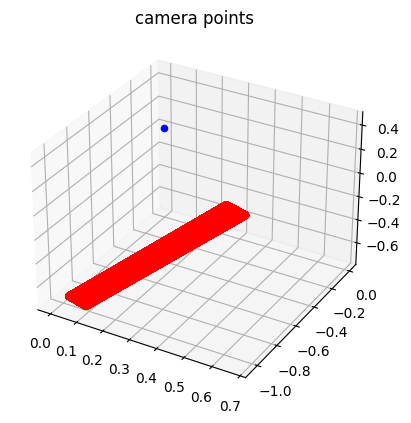

In [54]:
points = 1000000
z = rays_d[:points,0]	 # z坐标范围-50~50
x = rays_d[:points,1]
y = rays_d[:points,2]
ddd_points = np.zeros((points,3))
ddd_points[:,0] = z
ddd_points[:,1] = x
ddd_points[:,2] = y
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
ax.set_title('camera points')  # 设置本图名称
ax.scatter(x, y, z, c = 'r') 
ax.scatter(0, 0, 0, c = 'b') 

In [57]:
ndc = True
if ndc:
    # for forward facing scenes
    rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

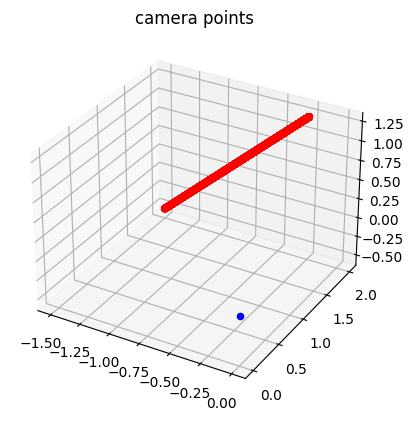

In [58]:
points = 10000
z = rays_d[:points,0]	 # z坐标范围-50~50
x = rays_d[:points,1]
y = rays_d[:points,2]
ddd_points = np.zeros((points,3))
ddd_points[:,0] = z
ddd_points[:,1] = x
ddd_points[:,2] = y
ax = plt.subplot(projection = '3d')  # 创建一个三维的绘图工程
ax.set_title('camera points')  # 设置本图名称
ax.scatter(x, y, z, c = 'r') 
ax.scatter(0, 0, 0, c = 'b') 